In [ ]:
from google.colab import drive
import librosa
import numpy as np
import os
from tqdm import tqdm

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# mfcc_extraction.py

#audi directory
AUDIO_DIR = '/content/drive/MyDrive/DL-Project/data/audio'
# saving matrix
SAVE_DIR = '/content/drive/MyDrive/DL-Project/data/features'
os.makedirs(SAVE_DIR, exist_ok=True)


def extract_mfcc_stats(data_dir):
    features = []
    track_ids = []
    # backup dict
    feature_dict = {}
    files = [f for f in os.listdir(data_dir) if f.endswith('.wav')]
    print(f"Found {len(files)} files. Starting extraction")

    for file in tqdm(files):
        try:
            file_path = os.path.join(data_dir, file)
            #loading
            y, sr = librosa.load(file_path, sr=None, duration=30)
            # extracting  MFCC(20 dimsf )
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
            # calculate Mean and Variance (compresses time dimension)
            mfcc_mean = np.mean(mfcc, axis=1)
            mfcc_var = np.var(mfcc, axis=1)

            # final vector has 40 dims
            feature_vector = np.concatenate((mfcc_mean, mfcc_var))
            features.append(feature_vector)
            # getting track id
            track_id = int(os.path.splitext(file)[0])
            track_ids.append(track_id)
             # dictionary backup
            feature_dict[track_id] = feature_vector

        except Exception as e:
            print(f"Error: {file} - {e}")

    return np.array(features), np.array(track_ids), feature_dict



if os.path.exists(os.path.join(SAVE_DIR, 'mfcc_features.npy')):
    print("Features already exist")
else:
    X, ids, feature_dict = extract_mfcc_stats(AUDIO_DIR)
    np.save(os.path.join(SAVE_DIR, 'mfcc_features.npy'), X)
    np.save(os.path.join(SAVE_DIR, 'track_ids.npy'), ids)
    # backup
    np.save(
        os.path.join(SAVE_DIR, 'BACKUP_mfcc_feature.npy'),
        feature_dict,
        allow_pickle=True
    )
    print("Saved features to Drive.")

Found 7997 files. Starting extraction


100%|██████████| 7997/7997 [55:25<00:00,  2.40it/s]


Saved features to Drive.


In [ ]:
# basic_vae.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os

# data loading
feature_path = '/content/drive/MyDrive/DL-Project/data/features/mfcc_features.npy'
X = np.load(feature_path)

# normalizing for better perf
mean = X.mean(axis=0)
std = X.std(axis=0)
X_scaled = (X - mean) / (std + 1e-6)
# converting to tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = TensorDataset(torch.FloatTensor(X_scaled).to(device))
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# basic VAE
class BasicVAE(nn.Module):
    def __init__(self, input_dim=40, latent_dim=10):
        super(BasicVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

# tarining with latent dim 8 ( will try out different dimentions laters dims 4,16)
model = BasicVAE(input_dim=40, latent_dim=8).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_fn(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

print("Starting VAE Training")
model.train()
for epoch in range(50):
    total_loss = 0
    for batch in dataloader:
        x_batch = batch[0]
        optimizer.zero_grad()
        recon, mu, logvar = model(x_batch)
        loss = loss_fn(recon, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: Loss {total_loss/len(dataset):.4f}")

# extracting latent feats
model.eval()
with torch.no_grad():
    full_tensor = torch.FloatTensor(X_scaled).to(device)
    _, mu_all, _ = model(full_tensor)
    Z_latent = mu_all.cpu().numpy()

# svaing Z_latent
np.save(os.path.join('/content/drive/MyDrive/DL-Project/data/features', 'vae_latent_features.npy'), Z_latent)

print(f"Training Done.Latent shape: {Z_latent.shape}")

Starting VAE Training
Epoch 10: Loss 23.6589
Epoch 20: Loss 22.3913
Epoch 30: Loss 22.0122
Epoch 40: Loss 21.8089
Epoch 50: Loss 21.5484
Training Done.Latent shape: (7997, 8)


Alignment check passed. Mapping 7997 tracks.
Tuning KMeans on VAE latent space...
Clusters: 2, Components: 8, Silhouette: 0.1535, CH: 1425.95
Clusters: 3, Components: 8, Silhouette: 0.1488, CH: 1399.62
Clusters: 4, Components: 8, Silhouette: 0.1522, CH: 1312.08
Clusters: 5, Components: 8, Silhouette: 0.1543, CH: 1243.53
Clusters: 6, Components: 8, Silhouette: 0.1549, CH: 1219.09
Clusters: 7, Components: 8, Silhouette: 0.1561, CH: 1162.52
Clusters: 8, Components: 8, Silhouette: 0.1509, CH: 1099.95
Clusters: 9, Components: 8, Silhouette: 0.1525, CH: 1034.55
Clusters: 10, Components: 8, Silhouette: 0.1489, CH: 991.52


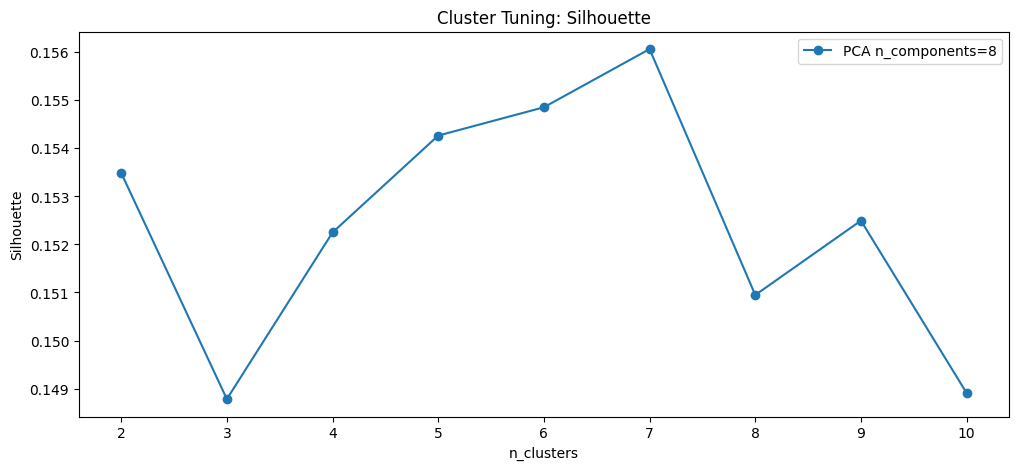

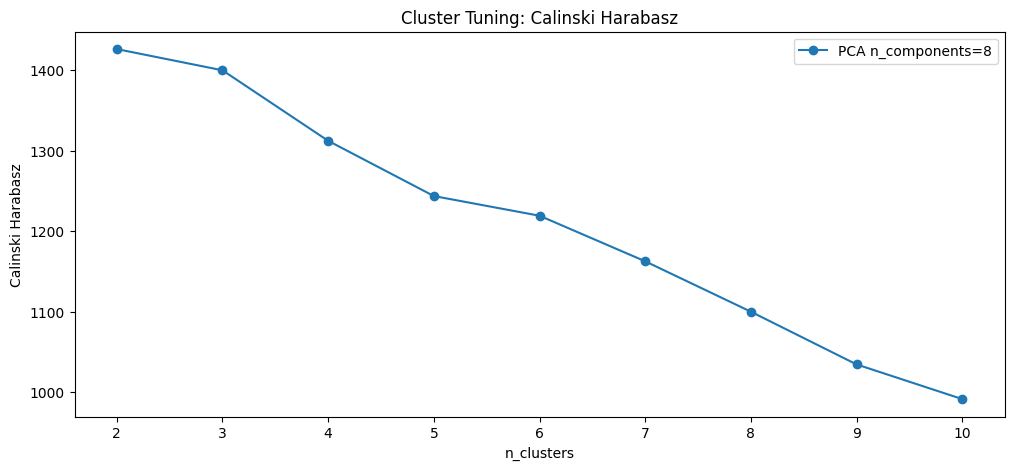

Best VAE KMeans: n_clusters=7, Silhouette=0.1561

Tuning PCA baseline...
Clusters: 2, Components: 6, Silhouette: 0.2529, CH: 2446.13
Clusters: 2, Components: 8, Silhouette: 0.2394, CH: 2222.96
Clusters: 2, Components: 10, Silhouette: 0.2304, CH: 2073.36
Clusters: 2, Components: 12, Silhouette: 0.2218, CH: 1969.36
Clusters: 3, Components: 6, Silhouette: 0.2011, CH: 2159.54
Clusters: 3, Components: 8, Silhouette: 0.1852, CH: 1931.12
Clusters: 3, Components: 10, Silhouette: 0.1751, CH: 1781.47
Clusters: 3, Components: 12, Silhouette: 0.1664, CH: 1679.62
Clusters: 4, Components: 6, Silhouette: 0.1952, CH: 1985.90
Clusters: 4, Components: 8, Silhouette: 0.1777, CH: 1751.93
Clusters: 4, Components: 10, Silhouette: 0.1650, CH: 1601.92
Clusters: 4, Components: 12, Silhouette: 0.1552, CH: 1501.32
Clusters: 5, Components: 6, Silhouette: 0.1729, CH: 1760.62
Clusters: 5, Components: 8, Silhouette: 0.1547, CH: 1521.87
Clusters: 5, Components: 10, Silhouette: 0.1446, CH: 1400.66
Clusters: 5, Compone

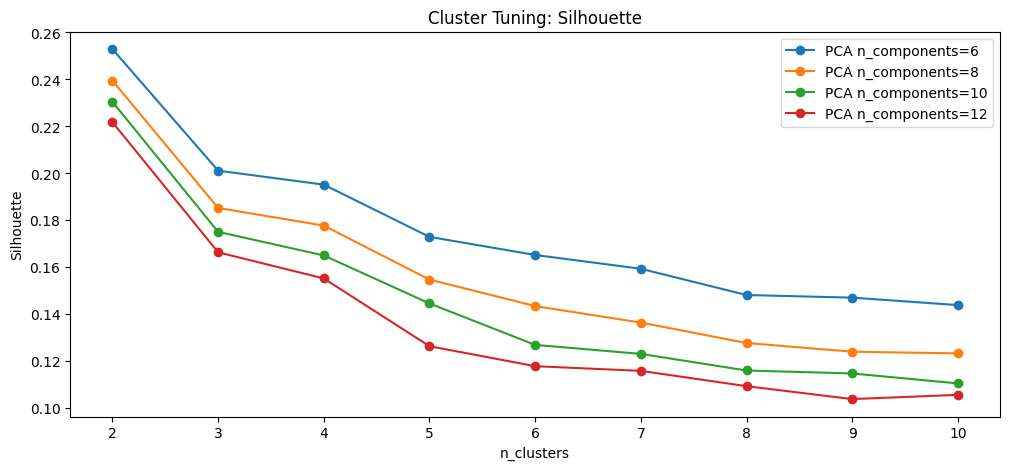

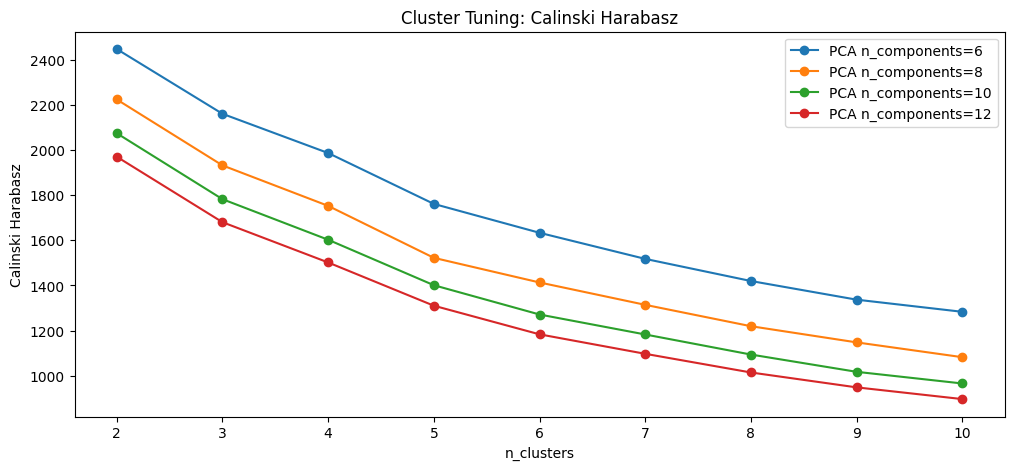

Best PCA KMeans: n_clusters=2, n_components=6, Silhouette=0.2529

--- VAE Method Results ---
Silhouette Score: 0.1561
Calinski-Harabasz: 1162.5249

--- Baseline (PCA) Results ---
Silhouette Score: 0.2392
Calinski-Harabasz: 2222.8955

Generating t-SNE Plot...

Saved mapped results to /content/drive/MyDrive/DL-project/results/clustering_results.csv


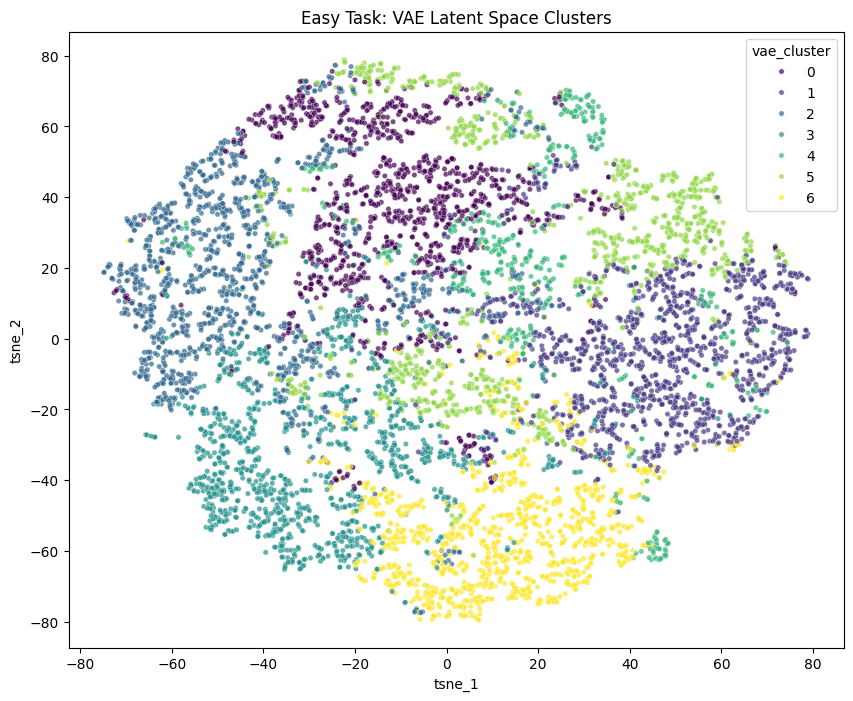

In [ ]:
# analysis_on_basic_VAE.py
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import itertools

cluster_range = range(2, 11)      # n_clusters for tuning
pca_range = [6, 8, 10, 12]        # n_components for tuning
results_path = '/content/drive/MyDrive/DL-project/results/clustering_results.csv'
os.makedirs(os.path.dirname(results_path), exist_ok=True)
# -----------------------------

# loading track ids
tid_path = '/content/drive/MyDrive/DL-Project/data/features/track_ids.npy'
track_ids = np.load(tid_path)
#loadind z_latent
Z_latent = np.load('/content/drive/MyDrive/DL-Project/data/features/vae_latent_features.npy')
# sanity check
assert len(track_ids) == len(Z_latent), f"Mismatch! IDs: {len(track_ids)}, Features: {len(Z_latent)}"
print(f"Alignment check passed. Mapping {len(track_ids)} tracks.")

# function to tune
def tune_clusters_pca(X, latent_space=None, cluster_range=range(2,11), pca_range=None, verbose=True, plot=True):
    results = []
    if latent_space is not None:
        X_space = latent_space
        pca_range = [X_space.shape[1]]  # only one dim for latent
    else:
        X_space = X
        if pca_range is None:
            pca_range = [min(X.shape[1], 8)]

    for n_clusters, n_comp in itertools.product(cluster_range, pca_range):
        if latent_space is None and n_comp < X.shape[1]:
            pca = PCA(n_components=n_comp)
            X_reduced = pca.fit_transform(X_space)
        else:
            X_reduced = X_space

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(X_reduced)

        sil = silhouette_score(X_reduced, labels)
        ch = calinski_harabasz_score(X_reduced, labels)

        results.append({'n_clusters': n_clusters, 'n_components': n_comp,
                        'silhouette': sil, 'calinski_harabasz': ch, 'labels': labels, 'kmeans': kmeans})

        if verbose:
            print(f"Clusters: {n_clusters}, Components: {n_comp}, Silhouette: {sil:.4f}, CH: {ch:.2f}")

    # Best by silhouette
    best = max(results, key=lambda x: x['silhouette'])

    if plot:
        for metric in ['silhouette', 'calinski_harabasz']:
            plt.figure(figsize=(12,5))
            for n_comp in sorted(set([r['n_components'] for r in results])):
                res = [r for r in results if r['n_components']==n_comp]
                plt.plot([r['n_clusters'] for r in res],
                         [r[metric] for r in res],
                         marker='o', label=f'PCA n_components={n_comp}')
            plt.xlabel("n_clusters")
            plt.ylabel(metric.replace('_',' ').title())
            plt.title(f"Cluster Tuning: {metric.replace('_',' ').title()}")
            plt.legend()
            plt.show()

    return best, results

# TUNINGN
print("Tuning KMeans on VAE latent space")
best_vae, _ = tune_clusters_pca(X_scaled, latent_space=Z_latent, cluster_range=cluster_range, verbose=True, plot=True)
clusters_vae = best_vae['labels']
kmeans_vae = best_vae['kmeans']
print(f"Best VAE KMeans: n_clusters={best_vae['n_clusters']}, Silhouette={best_vae['silhouette']:.4f}")

print("\nTuning PCA baseline")
best_pca, _ = tune_clusters_pca(X_scaled, latent_space=None, cluster_range=cluster_range, pca_range=pca_range, verbose=True, plot=True)
clusters_pca = best_pca['labels']
kmeans_pca = best_pca['kmeans']
print(f"Best PCA KMeans: n_clusters={best_pca['n_clusters']}, n_components={best_pca['n_components']}, Silhouette={best_pca['silhouette']:.4f}")

#  EVALUATION ----------
def get_metrics(data, labels, name):
    sil = silhouette_score(data, labels)
    ch = calinski_harabasz_score(data, labels)
    print(f"\n--- {name} Results ---")
    print(f"Silhouette Score: {sil:.4f}")
    print(f"Calinski-Harabasz: {ch:.4f}")
    return sil, ch

get_metrics(Z_latent, clusters_vae, "VAE Method")


#tsne
print("\nGenerating t-SNE Plot...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
z_embedded = tsne.fit_transform(Z_latent)


results_df = pd.DataFrame({
    'track_id': track_ids,
    'vae_cluster': clusters_vae,
    'tsne_1': z_embedded[:, 0],
    'tsne_2': z_embedded[:, 1]
})
results_df.to_csv(results_path, index=False)
print(f"\nSaved mapped results to {results_path}")

# plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=results_df,
    x='tsne_1',
    y='tsne_2',
    hue='vae_cluster',
    palette='viridis',
    s=15,
    alpha=0.7
)
plt.title("VAE Latent Space Clusters")
plt.show()